**Set environment**

In [21]:
import sys
sys.path.append('../')
from config_sing import *
show_env()

You are in: Singularity | singularity_proj_combeffect
    BASE DIRECTORY:     /mount/work
    PATH OF SOURCE:     /mount/work/source
    PATH OF EXECUTABLE: /mount/work/exe
    PATH OF ANNOTATION: /mount/work/annotation
    PATH OF PROJECT:    /mount/project
    PATH OF RESULTS:    /mount/work/out/proj_combeffect

Library imported:
    numpy, pandas, matplotlib.pyplot
    os, sys, time, gzip, glob



In [3]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from collections import Counter

import seaborn as sns
import xgboost as xgb
import shap
import json

from functools import partial, reduce
print = partial(print, flush=True)

### Set Samples
fun = np.core.defchararray.add
idx = np.arange(1,6).astype("str")

INPUT    = reduce(fun, ["Input", idx])
INPUT20X = reduce(fun, ["Input", idx,     "_20x"])
TFX_DMSO = reduce(fun, ["TFX",   idx[1:], "_DMSO"])
TFX_DEX  = reduce(fun, ["TFX",   idx[1:], "_Dex"])
SAMPLES  = np.concatenate([INPUT20X, TFX_DMSO, TFX_DEX])

In [4]:
%load_ext rpy2.ipython

## Import data

In [5]:
def read_data(sample):
    fdiry = os.path.join(FD_RES, "scratch", "region_dex_GR_P300_dnase_chr17")
    fname = f"{sample}_motif_score.tsv"
    fpath = os.path.join(fdiry, fname)
    dat   = pd.read_csv(fpath, sep = "\t", names=["Fragment", "Motif_Count"])
    return dat

In [6]:
fun = read_data
lst = list(map(fun, TFX_DMSO))

fun = lambda df1, df2: pd.concat([df1, df2])
dat = reduce(fun, lst)

### assign and show
dat_tfx_dmso = dat
print(dat.shape)
dat

(10802, 2)


,Fragment,Motif_Count
0,chr17_6001570_6002624,"{""HD/23"": 10.0246, ""SOX/1"": 15.42495, ""EVI1/ME..."
1,chr17_6001571_6002624,"{""SOX/1"": 15.42495, ""EVI1/MECOM"": 7.0973, ""ZNF..."
2,chr17_6001762_6002691,"{""ZNF549"": 13.8719, ""FEZF1"": 15.2109, ""GCM"": 7..."
3,chr17_6001762_6002692,"{""ZNF549"": 13.8719, ""FEZF1"": 15.2109, ""GCM"": 7..."
4,chr17_6001763_6002692,"{""ZNF549"": 13.8719, ""FEZF1"": 15.2109, ""GCM"": 7..."
...,...,...
2606,chr17_82268021_82268899,"{""NR/4"": 8.857, ""E2F/2"": 18.1223, ""ZFX"": 18.50..."
2607,chr17_82268031_82268998,"{""Ebox/CAGATGG"": 25.37525, ""ZNF768"": 19.6749, ..."
2608,chr17_82268031_82268999,"{""Ebox/CAGATGG"": 25.37525, ""ZNF768"": 19.6749, ..."
2609,chr17_82268032_82268997,"{""Ebox/CAGATGG"": 25.37525, ""ZNF768"": 19.6749, ..."


In [7]:
fun = read_data
lst = list(map(fun, TFX_DEX))

fun = lambda df1, df2: pd.concat([df1, df2])
dat = reduce(fun, lst)

### assign and show
dat_tfx_dex = dat
print(dat.shape)
dat

(39176, 2)


,Fragment,Motif_Count
0,chr17_6001786_6002741,"{""SIX/1"": 8.5294, ""HIC/1"": 24.9856, ""P53-like/..."
1,chr17_6001796_6002785,"{""HIC/1"": 24.9856, ""P53-like/1"": 18.1449, ""GC-..."
2,chr17_6001796_6002786,"{""HIC/1"": 24.9856, ""P53-like/1"": 18.1449, ""GC-..."
3,chr17_6001797_6002783,"{""HIC/1"": 24.9856, ""P53-like/1"": 18.1449, ""GC-..."
4,chr17_6001797_6002786,"{""HIC/1"": 24.9856, ""P53-like/1"": 18.1449, ""GC-..."
...,...,...
11873,chr17_82267754_82268685,"{""MAF"": 9.6645, ""Ebox/CAGATGG"": 35.51705, ""ZNF..."
11874,chr17_82267762_82268716,"{""ZNF320"": 21.0008, ""GC-tract"": 53.11818, ""SMA..."
11875,chr17_82267763_82268716,"{""ZNF320"": 21.0008, ""GC-tract"": 53.11818, ""SMA..."
11876,chr17_82267768_82268716,"{""SMARCA5"": 11.531, ""ZNF143"": 6.6565, ""ZNF134""..."


## Combine and arrange

In [8]:
lst = dat_tfx_dmso["Motif_Count"].to_list() + dat_tfx_dex["Motif_Count"].to_list()
lst = list(map(json.loads, lst))
dat = pd.DataFrame.from_dict(lst).fillna(0)

###
dat_comb = dat
print(dat.shape)
dat

(49978, 269)


,HD/23,SOX/1,EVI1/MECOM,ZNF768,NFY,EBF1,GC-tract,ZNF320,CTCF,KLF/SP/2,...,HSFY2,NR/4,ZNF713,TATA,AHR,ARI5B,GMEB2/1,ZBTB14,GMEB2/2,KAISO
0,10.0246,15.42495,7.0973,7.0552,7.4972,8.3990,78.25626,17.3581,14.9269,83.21312,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0000,15.42495,7.0973,7.0552,7.4972,8.3990,78.25626,17.3581,14.9269,83.21312,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0000,15.96585,0.0000,0.0000,0.0000,0.0000,59.84730,0.0000,6.1980,64.11863,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0000,15.96585,0.0000,0.0000,0.0000,0.0000,59.84730,0.0000,6.1980,64.11863,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0000,15.96585,0.0000,0.0000,0.0000,0.0000,59.84730,0.0000,6.1980,64.11863,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49973,0.0000,6.82580,0.0000,29.9513,0.0000,9.5487,53.11818,21.0008,26.5810,29.74041,...,0.0,8.857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49974,0.0000,6.82580,0.0000,29.9513,0.0000,9.5487,53.11818,21.0008,26.5810,29.74041,...,0.0,8.857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49975,0.0000,6.82580,0.0000,29.9513,0.0000,9.5487,53.11818,21.0008,26.5810,29.74041,...,0.0,8.857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49976,0.0000,6.82580,0.0000,29.9513,0.0000,9.5487,43.15858,9.6538,26.5810,29.74041,...,0.0,8.857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train XGBoost model

In [9]:
dat = dat_comb
ftr = dat.columns.values
X   = dat #.values
y   = np.r_[np.repeat(0, dat_tfx_dmso.shape[0]), np.repeat(1, dat_tfx_dex.shape[0])]

print(type(X),   X.shape)
print(type(y),   y.shape)
print(type(ftr), ftr.shape)
Counter(y)

<class 'pandas.core.frame.DataFrame'> (49978, 269)
<class 'numpy.ndarray'> (49978,)
<class 'numpy.ndarray'> (269,)


Counter({0: 10802, 1: 39176})

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [25]:
Counter(y_test)

Counter({1: 9782, 0: 2713})

In [11]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
print(); print(model)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


## Performance

In [12]:
y_expc = y_test
y_pred = model.predict(X_test)

print(metrics.classification_report(y_expc, y_pred))
print(metrics.confusion_matrix(y_expc, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.22      0.33      2714
           1       0.82      0.98      0.89      9781

    accuracy                           0.81     12495
   macro avg       0.77      0.60      0.61     12495
weighted avg       0.80      0.81      0.77     12495

[[ 589 2125]
 [ 223 9558]]


## Important score

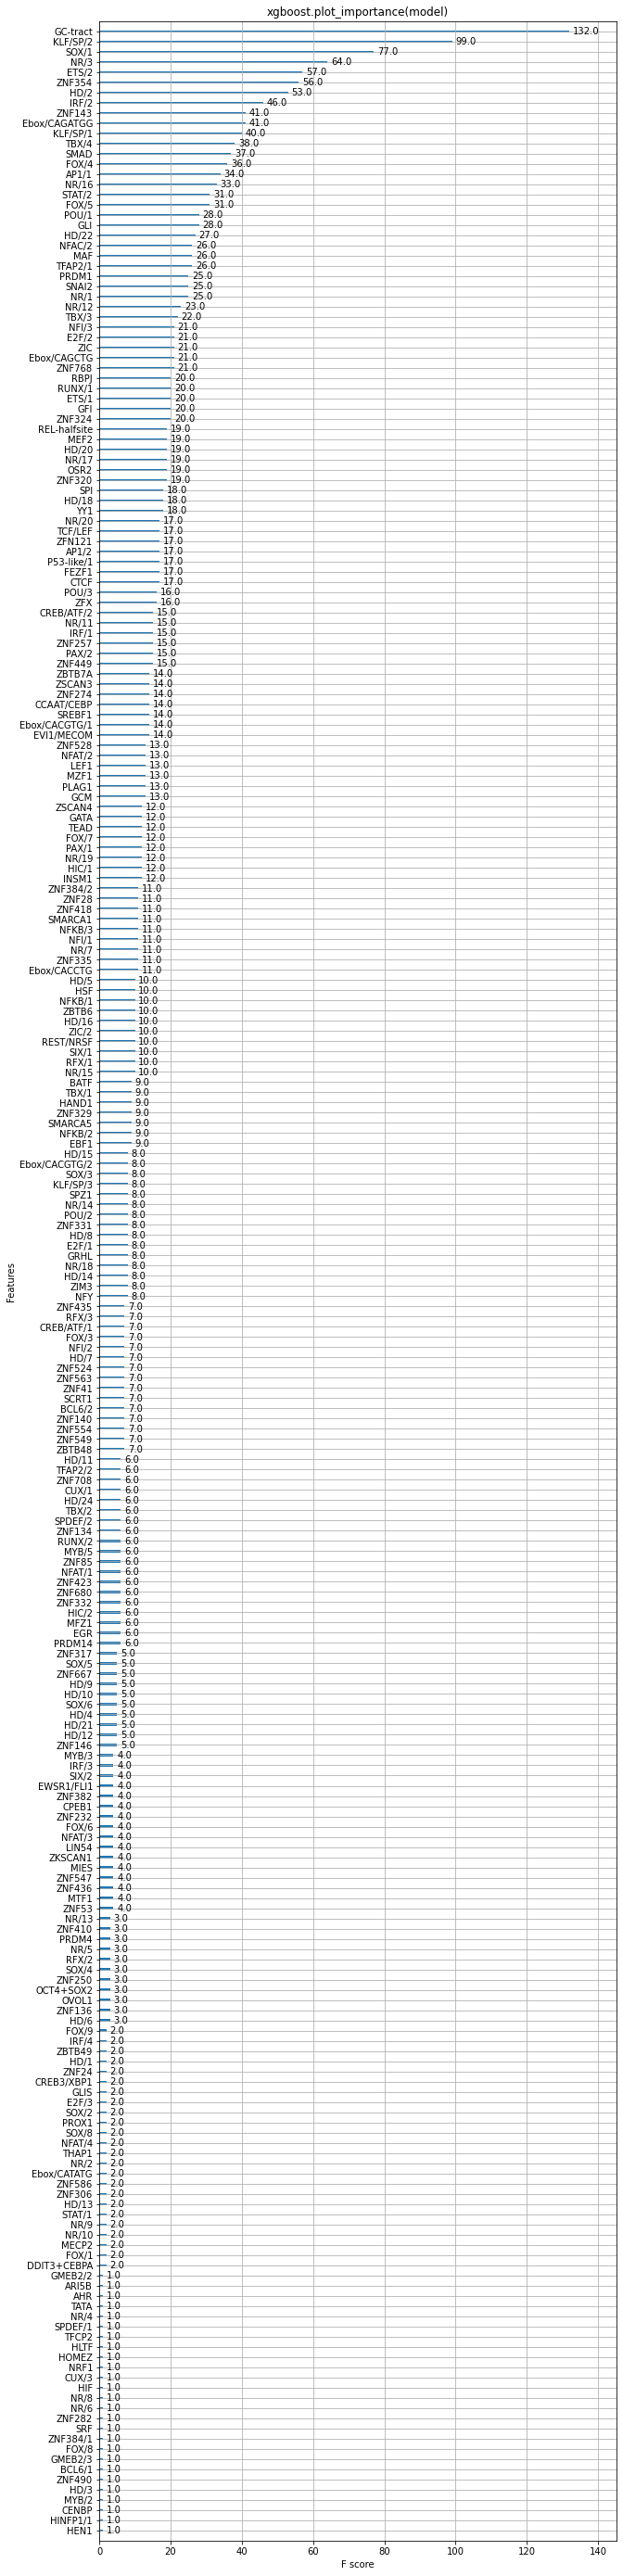

In [13]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 50))
xgb.plot_importance(model, ax = ax)
ax.set_title("xgboost.plot_importance(model)")
plt.show()

## SHAP Calculation

In [14]:
X_tmp  = X_train
n_tot  = X_tmp.shape[0]
n_size = 1000
idx    = np.random.permutation(np.arange(n_tot))[:n_size]
X_tmp  = X_tmp.iloc[idx]

print(n_tot)
print(X_tmp.shape)

37483
(1000, 269)


In [15]:
explainer = shap.TreeExplainer(model)

In [16]:
%%time
shap_values = explainer.shap_values(X_tmp)
print(shap_values.shape)

(1000, 269)
CPU times: user 1.94 s, sys: 6.71 ms, total: 1.95 s
Wall time: 208 ms


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [17]:
%%time
shap_interaction = explainer.shap_interaction_values(X_tmp)
print(shap_interaction.shape)

(1000, 269, 269)
CPU times: user 15min 45s, sys: 248 ms, total: 15min 45s
Wall time: 1min 34s


## SHAP interaction values

In [18]:
#Get model predictions
y_pred = model.predict(X_tmp)

#Calculate mean prediction 
mean_pred = np.mean(y_pred)

#Sum of interaction values for first employee
sum_shap = np.sum(shap_interaction[0])

#Values below should be the same
print("Model prediction: {}".format(y_pred[0]))
print("Mean prediction + interaction values: {}".format(mean_pred+sum_shap))

Model prediction: 1
Mean prediction + interaction values: 1.3740828182697298


In [19]:
# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap,index=X.columns,columns=X.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2,inplace=True)
print(df.shape)

(269, 269)


In [20]:
df

,HD/23,SOX/1,EVI1/MECOM,ZNF768,NFY,EBF1,GC-tract,ZNF320,CTCF,KLF/SP/2,...,HSFY2,NR/4,ZNF713,TATA,AHR,ARI5B,GMEB2/1,ZBTB14,GMEB2/2,KAISO
HD/23,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
SOX/1,0.0,0.016291,0.001727,0.000043,0.001207,0.000000e+00,0.008188,0.000286,0.000620,0.003989,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000006,0.0
EVI1/MECOM,0.0,0.001727,0.003592,0.000000,0.000000,0.000000e+00,0.000578,0.000000,0.000000,0.000243,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
ZNF768,0.0,0.000043,0.000000,0.008768,0.000000,0.000000e+00,0.004051,0.000000,0.000000,0.000207,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
NFY,0.0,0.001207,0.000000,0.000000,0.007521,1.835740e-07,0.000216,0.000000,0.000006,0.001083,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ARI5B,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.001902,0.0,0.0,0.000000,0.0
GMEB2/1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
ZBTB14,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
GMEB2/2,0.0,0.000006,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.006183,0.0


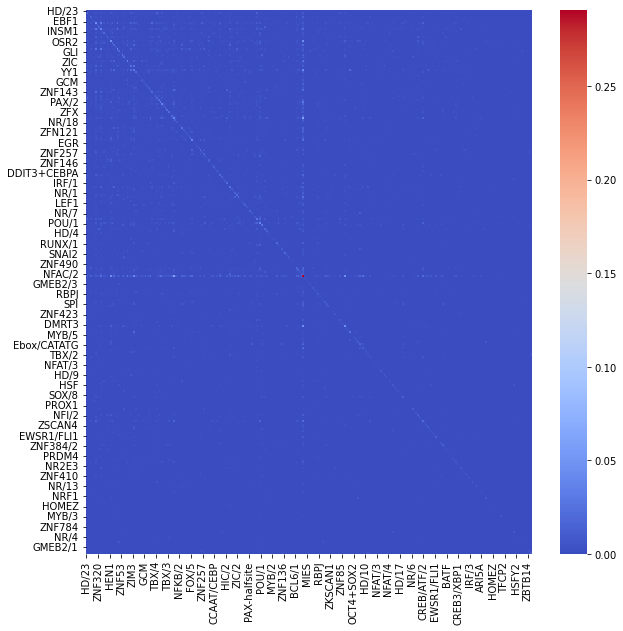

In [28]:
# display 
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.heatmap(df,cmap='coolwarm')

In [29]:
type(df)

pandas.core.frame.DataFrame

In [48]:
%%R
suppressMessages(source("../config_sing.R"))
show_env()

You are in Singularity: singularity_proj_combeffect 
BASE DIRECTORY:     /mount/work 
PATH OF SOURCE:     /mount/work/source 
PATH OF EXECUTABLE: /mount/work/exe 
PATH OF ANNOTATION: /mount/work/annotation 
PATH OF PROJECT:    /mount/project 
PATH OF RESULTS:    /mount/work/out/proj_combeffect 


In [41]:
%%R -i df
dat_shap = df
print(class(dat_shap))
dat_shap[1:6, 1:5]

[1] "data.frame"
                  HD/23        SOX/1   EVI1/MECOM       ZNF768          NFY
HD/23      0.0009164512 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
SOX/1      0.0000000000 1.847057e-02 8.441079e-05 4.260466e-04 0.000000e+00
EVI1/MECOM 0.0000000000 8.441074e-05 2.349287e-03 7.367795e-04 0.000000e+00
ZNF768     0.0000000000 4.260466e-04 7.367791e-04 1.324518e-02 7.420191e-05
NFY        0.0000000000 0.000000e+00 0.000000e+00 7.420195e-05 4.389432e-03
EBF1       0.0000000000 2.431302e-04 0.000000e+00 0.000000e+00 0.000000e+00


In [42]:
%%R
dat = dat_shap
tmp = apply(dat, 1, sum)
print(head(tmp))
cat("+++++++++++++++++++++++++++++\n")
idx = which.max(tmp)
print(tmp[idx])

      HD/23       SOX/1  EVI1/MECOM      ZNF768         NFY        EBF1 
0.005273439 0.242384540 0.023400355 0.144321083 0.024802026 0.034018256 
+++++++++++++++++++++++++++++
   NR/20 
1.602444 


In [43]:
%%R
dat = dat_shap
dat = apply(dat, 1, sum)
dat = data.frame(Motif = names(dat), Score = dat)
head(dat)

                Motif       Score
HD/23           HD/23 0.005273439
SOX/1           SOX/1 0.242384540
EVI1/MECOM EVI1/MECOM 0.023400355
ZNF768         ZNF768 0.144321083
NFY               NFY 0.024802026
EBF1             EBF1 0.034018256


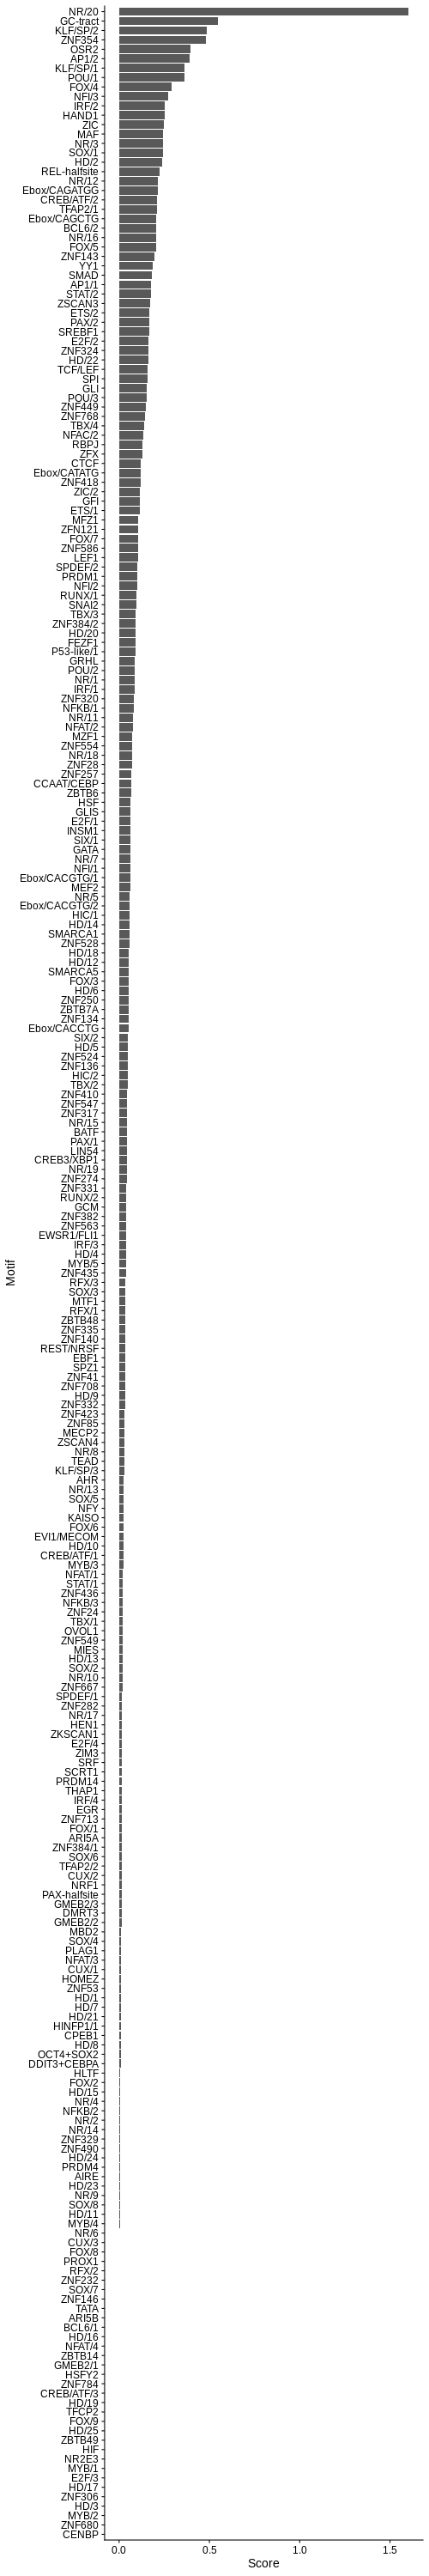

In [62]:
%%R -w 500 -h 3000
dat = dat_shap
dat = apply(dat, 1, sum)
dat = data.frame(Motif = names(dat), Score = dat) %>% arrange(Score)

dat$Motif = factor(dat$Motif, levels=dat$Motif)
gpt = ggplot(dat, aes(x=Motif, y=Score)) + 
    geom_histogram(stat="identity") +
    coord_flip() + 
    theme_cowplot()
print(gpt)

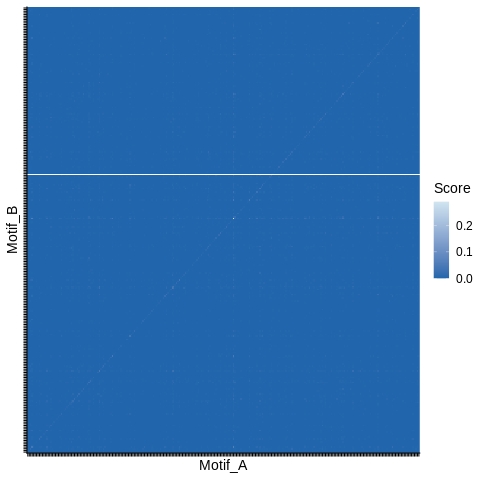

In [89]:
%%R
dat = dat_shap
dat = apply(dat, 1, sum)
dat = data.frame(Motif = names(dat), Score = dat) %>% arrange(Score)
mtf = dat$Motif

dat = dat_shap
dat = dat %>% rownames_to_column(var="Motif_A") %>% gather(Motif_B, Score, -Motif_A)

gpt = ggplot(dat, aes(x=Motif_A, y=Motif_B, fill=Score)) + 
    geom_tile() + 
    scale_fill_gradient(
        low  = "#2166ac",
        high = "#d1e5f0"
    ) +
    theme_cowplot() +
    theme(axis.text = element_blank())
    
print(gpt)

In [ ]:
print(1)

In [45]:
tmp = df.sum(axis = 0)
tmp.shape

(269,)

In [46]:
tmp

HD/23         0.005494
SOX/1         0.220306
EVI1/MECOM    0.047935
ZNF768        0.155746
NFY           0.027414
                ...   
ARI5B         0.004429
GMEB2/1       0.000000
ZBTB14        0.000000
GMEB2/2       0.005541
KAISO         0.005741
Length: 269, dtype: float32

In [57]:
tmp.sort_values()

E2F/4       0.000000
ZNF490      0.000000
E2F/3       0.000000
MYB/1       0.000000
NR2E3       0.000000
              ...   
ZNF354      0.433970
GC-tract    0.504616
KLF/SP/2    0.559799
AP1/2       0.603159
NR/20       1.686479
Length: 269, dtype: float32

In [32]:
df["NR/20"]

HD/23         0.000543
SOX/1         0.011381
EVI1/MECOM    0.000000
ZNF768        0.007901
NFY           0.001636
                ...   
ARI5B         0.000000
GMEB2/1       0.000000
ZBTB14        0.000000
GMEB2/2       0.000000
KAISO         0.000218
Name: NR/20, Length: 269, dtype: float32

In [27]:
# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap,index=X.columns,columns=X.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2,inplace=True)

# display 
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(df,cmap='coolwarm',annot=True,fmt='.3g',cbar=False)
plt.yticks(rotation=0) 

(array([  0.5,   9.5,  18.5,  27.5,  36.5,  45.5,  54.5,  63.5,  72.5,
         81.5,  90.5,  99.5, 108.5, 117.5, 126.5, 135.5, 144.5, 153.5,
        162.5, 171.5, 180.5, 189.5, 198.5, 207.5, 216.5, 225.5, 234.5,
        243.5, 252.5, 261.5]),
 <a list of 30 Text major ticklabel objects>)

Error in callback <function flush_figures at 0x7fb698aba4d0> (for post_execute):


KeyboardInterrupt: 

In [28]:
print(1)

1


In [115]:
len(ftr)

269

In [116]:
idx = dat.columns.values
shap.bar_plot(
    shap_values,
    feature_names=ftr,
    max_display=20)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()